<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 直線フィッティング

誤差分布は外れ値が大きいコーシー分布

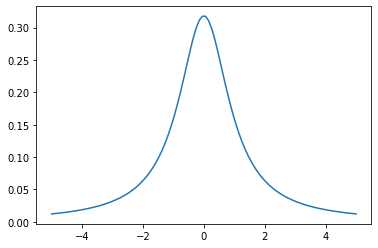

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def cauchy(x: np.ndarray):
    return 1/np.pi/(1+x*x)

x = np.linspace(-5, 5, 100)
y = cauchy(x)

plt.plot(x, y)
plt.show()

サンプルデータ生成

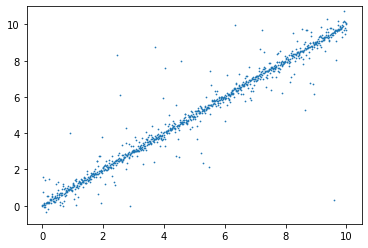

In [43]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.ylim(-1, 11)
plt.show()

iteration の回数の目安は以下の通り：

1. データ分布から、1回のサンプリングで inlier を引き当てる確率 $e$ を仮定
2. 1回の試行でのサンプル数を $n$ とすると、それらのサンプルが全て inlier である確率は $e^n$
3. 一方で$N$回の試行で 2. が1回も生じない場合(RANSAC が失敗する場合)の確率は$(1-e^n)^N$
4. つまり RANSAC をほぼ確実(確率$p\sim1$)で成功させたい場合は
\begin{equation}
1-p=(1-e^n)^N⇔N=\frac{\ln(1-p)}{\ln(1-e^n)}
\end{equation}
くらいの$N$に設定して反復する。
4. 更に早期終了を目指す場合は、最大の inlier 数更新のタイミングで $e\sim$  (inlier とした数)/(データ数) として$N$を更新

In [44]:
# データの目視確認より 9/10 は対象データと想定
e = 9/10
# 直線のパラメータは2個 → サンプリング数は2個で十分
n = 2
# 99.99% の確率で RANSAC を成功させる
p = 0.9999
# zero division error 対策
max_iteration = int(np.log(1-p)/_) if not np.isclose((_ := np.log(1-e**n)), 0) else 1e+5

print(max_iteration)

5


乱数生成

In [45]:
index_mat = np.random.randint(0, point_num, (max_iteration, 2))
print(index_mat)

[[461 924]
 [495 869]
 [475 322]
 [482 940]
 [951 187]]


ランダムサンプリング

In [46]:
np.array([x[index_mat], y[index_mat]]).shape

(2, 5, 2)

In [47]:
# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)

print(samples_tensor.shape)
print(samples_tensor)

(5, 2, 2)
[[[ 4.61461461  4.53407636]
  [ 9.24924925  9.2183145 ]]

 [[ 4.95495495  5.04069661]
  [ 8.6986987   8.81414208]]

 [[ 4.75475475  4.52599911]
  [ 3.22322322  3.23269105]]

 [[ 4.82482482  4.95265298]
  [ 9.40940941  9.56258389]]

 [[ 9.51951952 18.80421025]
  [ 1.87187187  1.90024839]]]


傾きと切片計算

In [48]:
params_tensor = np.array([np.polyfit(sample[:, 0], sample[:, 1], 1) 
                          for sample in samples_tensor])

inlier の数を計算 → 最も良い候補を選択

In [49]:
def polynomial(params, points):
    max_degree = len(params)
    # shape=(params, points)
    terms = np.array([params[degree] * points[:, 0] ** (max_degree - degree - 1)
                      for degree in range(max_degree)])
    return np.sum(terms, axis=0)

def get_distances(params, points):
    y_est = polynomial(params, points)
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

1


結果を確認

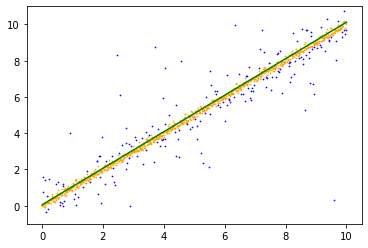

In [50]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(params, points),
         color="green")
plt.ylim(-1, 11)
plt.show()

再フィッティング

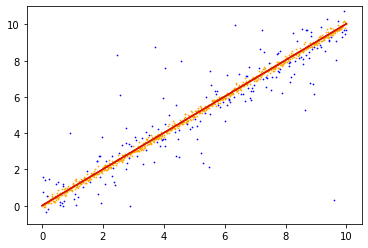

In [51]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 1)

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.ylim(-1, 11)
plt.show()

## 2次曲線フィッティング

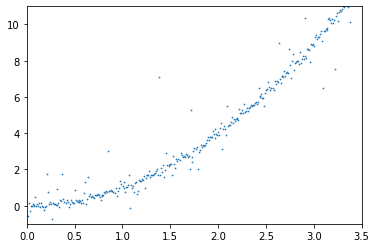

In [52]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x**2 + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

In [53]:
e = 6/10
n = 3
p = 0.9999
max_iteration = int(np.log(1-p)/_) if not np.isclose((_ := np.log(1-e**n)), 0) else 1e+5

print(max_iteration)

37


In [54]:
index_mat = np.random.randint(0, point_num, (max_iteration, 3))

# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)
print(samples_tensor.shape)

(37, 3, 2)


In [55]:
params_tensor = np.array([
    np.polyfit(sample[:, 0], sample[:, 1], 2)
    for sample in samples_tensor])

In [56]:
def get_distances(params, points):
    y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

13


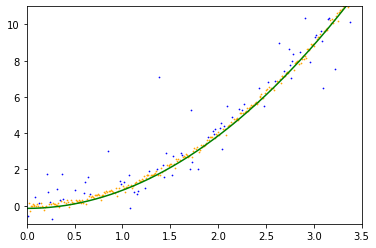

In [57]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
plt.plot(points[:, 0], y_est, color="green")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

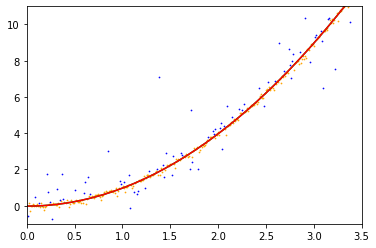

In [58]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 2)
y_refined =  refined_params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")


plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()